# Домашнее задание 3. Свёрточные и рекуррентные нейронные сети
## Першаев Никита ИУ8-83

В зависимости от варианта, для решения задачи используйте следующие наборы данных:

<table>
    <thead>
         <tr>
            <th colspan=1>Задача генерации</th>
            <th colspan=5>Задача классификации</th>
        </tr>
        <tr>
            <th> </th>
            <th>A</th>
            <th>B</th>
            <th>C</th>
            <th>D</th>
            <th>E</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>K</td>
            <td>1</td>
            <td>2</td>
            <td>3</td>
            <td>4</td>
            <td>5</td>
        </tr>
        <tr>
            <td>L</td>
            <td>6</td>
            <td>7</td>
            <td>8</td>
            <td>9</td>
            <td>10</td>
        </tr>
        <tr>
            <td>M</td>
            <td>11</td>
            <td>12</td>
            <td>13</td>
            <td>14</td>
            <td>15</td>
        </tr>
        <tr>
            <td>N</td>
            <td>16</td>
            <td>17</td>
            <td>18</td>
            <td>19</td>
            <td>20</td>
        </tr>
        <tr>
            <td>O</td>
            <td>21</td>
            <td>22</td>
            <td>23</td>
            <td>24</td>
            <td>25</td>
        </tr>
    </tbody>
</table>

### Наборы данных

**Задача классификации картинок**

A. [Набор данных "Fashion MNIST"](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) `torchvision.datasets.FashionMNIST train=True и False`

B. [Набор данных "Текстуры"](https://pytorch.org/vision/main/generated/torchvision.datasets.DTD.html#torchvision.datasets.DTD) `torchvision.datasets.DTD split='train' и 'test'`

C. [Набор данных "Буквы"](https://pytorch.org/vision/main/generated/torchvision.datasets.EMNIST.html#torchvision.datasets.EMNIST) `torchvision.datasets.EMNIST split=letters train=True и False`

D. [Набор данных "Кошки и собаки"](https://pytorch.org/vision/main/generated/torchvision.datasets.OxfordIIITPet.html) `torchvision.datasets.OxfordIIITPet split = 'trainval' и 'test'` (объекты разбиты по породам (всего 37 пород), нужно построить бинарный классификатор собак и кошек)

E. [Набор данных "Дорожные знаки"](https://pytorch.org/vision/main/generated/torchvision.datasets.GTSRB.html) `torchvision.datasets.GTSRB split = 'train' и 'test'`


---

**Задача генерации текстов**

K. [Набор данных "Евгений Онегин"]() `onegin.txt`

L. [Набор данных "Война и Мир"]() `war_and_piece.txt`

M. [Набор данных "Стихи"]() `stihi.csv`

N. [Набор данных "Сказки"]() `fairytales.txt`

O. [Набор данных "Новости"]() `news.txt` или https://github.com/yutkin/Lenta.Ru-News-Dataset/releases

# 0. Инициализация библиотек

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
from collections import Counter

# 1. Свёрточная нейронная сеть для классификации изображений (9 баллов)

## 1.1 Загрузка данных, разделение на train и test

Загрузите данные при помощи torchvision.datasets. Можете предусмотреть опредлённые транфсофрмации картинки, например, изменение размера до 128 px, кроп по центру в 196 px и преобразование к классу torch.Tensor:

```
import torchvision


transform = torchvision.transforms.Compose([
    # resize
    torchvision.transforms.Resize(128),
    torchvision.transforms.CenterCrop(196),
    torchvision.transforms.ToTensor()
])
```

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = torchvision.datasets.GTSRB('train_data', download=True, split='train', transform=transform)
test_data = torchvision.datasets.GTSRB('test_data', download=True, split='test', transform=transform)

In [3]:
trainDataLoaded = DataLoader(
    train_data,
    batch_size=512,
    shuffle=True,
    num_workers=2
)

testDataLoaded = DataLoader(
    test_data,
    batch_size=512,
    shuffle=False,
    num_workers=2
)

## 1.2 Предобработка данных (по необходимости)

In [5]:
for x in trainDataLoaded:
    print(type(x), type(x[0]), x[0].shape, type(x[1]), x[1].shape)
    break

<class 'list'> <class 'torch.Tensor'> torch.Size([512, 3, 32, 32]) <class 'torch.Tensor'> torch.Size([512])


## 1.3 Инициализация объекта свёрточной нейронной сети

Создайте нейронную сеть с 2-4 свёрточными слоями. В остальном конфигурация сети может быть произвольной. 

In [6]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_1 = torch.nn.Conv2d(3, 30, 3)
        self.conv_2 = torch.nn.Conv2d(30, 90, 3)
        self.conv_3 = torch.nn.Conv2d(90, 120, 3)
        self.conv_4 = torch.nn.Conv2d(120, 180, 2)
        

        self.flatten = torch.nn.Flatten()
        self.lin_1 = torch.nn.Linear(180, 90)
        self.lin_2 = torch.nn.Linear(90, 43)

        self.activ = torch.nn.ELU()
        self.max_pool = torch.nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.activ(x)
        x = self.max_pool(x)

        x = self.conv_2(x)
        x = self.activ(x)
        x = self.max_pool(x)

        x = self.conv_3(x)
        x = self.activ(x)
        x = self.max_pool(x)

        x = self.conv_4(x)
        x = self.activ(x)

        x = self.flatten(x)
        x = self.lin_1(x)
        x = self.activ(x)
        x = self.lin_2(x)

        return x

## 1.4 Обучение сввёрточной нейронной сети для решения задачи классификации

In [4]:
import torchvision.models as models

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)
epochs = 100

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(epochs):
  model.train()
  epoch_loss = 0
  epoch_pred = 0
  epoch_len = 0

  for batchData, batchRes in trainDataLoaded:
    batchData, batchRes = batchData.to(device), batchRes.to(device)

    optimizer.zero_grad()

    prediction = model(batchData)
    loss = criterion(prediction, batchRes)
    epoch_loss += loss.item()

    loss.backward()
    optimizer.step()

    _, prediction = torch.max(prediction.data, 1)
    epoch_pred += (prediction == batchRes).sum().item()
    epoch_len += batchRes.size(0)

  train_loss.append(epoch_loss / len(trainDataLoaded))
  train_accuracy.append(epoch_pred / epoch_len)

  model.eval()
  epoch_loss = 0
  epoch_pred = 0
  epoch_len = 0

  for batchData, batchRes in testDataLoaded:
    batchData, batchRes = batchData.to(device), batchRes.to(device)
    prediction = model(batchData)

    loss = criterion(prediction, batchRes)
    epoch_loss += loss.item()

    _, prediction = torch.max(prediction.data, 1)
    epoch_pred += (batchRes == prediction).sum().item()
    epoch_len += batchRes.size(0)
  
  test_loss.append(epoch_loss / len(testDataLoaded))
  test_accuracy.append(epoch_pred / epoch_len)

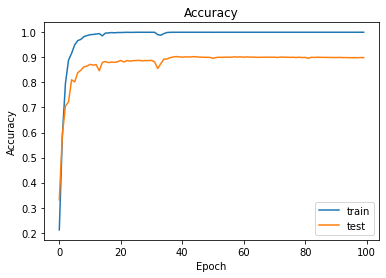

In [9]:
figure = plt.figure().gca()
figure.plot(train_accuracy)
figure.plot(test_accuracy)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy')
plt.show()

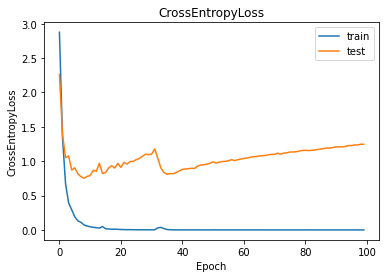

In [10]:
figure = plt.figure().gca()
figure.plot(train_loss)
figure.plot(test_loss)
plt.ylabel('CrossEntropyLoss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('CrossEntropyLoss')
plt.show()

## 1.5 Агументация данных и регулряизации нейросети

Попобуйте добавить аугументацию (случайные повороты, увеличение, уменьшение) в данные, а также регуляризацию (Drop out и Batch Norm слои) в модель. Как меняется метрика accuracy на обучающей и тестовой выборке в процессе обучения? Постройте график.

In [5]:
augmentation_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((48, 48)),
    torchvision.transforms.RandomCrop((32, 32)),
    torchvision.transforms.RandomHorizontalFlip(p=0.25),
    torchvision.transforms.RandomVerticalFlip(p=0.25),
    torchvision.transforms.RandomRotation(degrees=(-90, 90)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5),
                                     (0.5, 0.5, 0.5))
])

In [6]:
aug_train_data = torchvision.datasets.GTSRB('train_data',
                                            download=True,
                                            split='train',
                                            transform=augmentation_transform)

augTrainDataLoaded = DataLoader(
    aug_train_data,
    batch_size=512,
    shuffle=True,
    num_workers=2
)

In [7]:
class NetReg(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_1 = torch.nn.Conv2d(3, 30, 3)
        self.batch_1 = torch.nn.BatchNorm2d(30)
        self.conv_2 = torch.nn.Conv2d(30, 90, 3)
        self.batch_2 = torch.nn.BatchNorm2d(90)
        self.conv_3 = torch.nn.Conv2d(90, 120, 3)
        self.batch_3 = torch.nn.BatchNorm2d(120)
        self.conv_4 = torch.nn.Conv2d(120, 180, 2)
        

        self.flatten = torch.nn.Flatten()
        self.batch_4 = torch.nn.BatchNorm1d(180)
        self.lin_1 = torch.nn.Linear(180, 90)
        self.batch_5 = torch.nn.BatchNorm1d(90)
        self.lin_2 = torch.nn.Linear(90, 43)

        self.activ = torch.nn.ELU()
        self.max_pool = torch.nn.MaxPool2d(2, 2)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.activ(x)
        x = self.max_pool(x)
        x = self.batch_1(x)
        x = self.dropout(x)

        x = self.conv_2(x)
        x = self.activ(x)
        x = self.max_pool(x)
        x = self.batch_2(x)
        x = self.dropout(x)

        x = self.conv_3(x)
        x = self.activ(x)
        x = self.max_pool(x)
        x = self.batch_3(x)
        x = self.dropout(x)

        x = self.conv_4(x)
        x = self.activ(x)
        x = self.dropout(x)

        x = self.flatten(x)
        x = self.batch_4(x)
        x = self.lin_1(x)
        x = self.activ(x)
        x = self.batch_5(x)
        x = self.dropout(x)
        x = self.lin_2(x)

        return x

## 1.6 Обучение нейросети на данных с аугументацией 

In [8]:
model = NetReg().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)
epochs = 100

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(epochs):
  model.train()
  epoch_loss = 0
  epoch_pred = 0
  epoch_len = 0

  for batchData, batchRes in augTrainDataLoaded:
    batchData, batchRes = batchData.to(device), batchRes.to(device)

    optimizer.zero_grad()

    prediction = model(batchData)
    loss = criterion(prediction, batchRes)
    epoch_loss += loss.item()

    loss.backward()
    optimizer.step()

    _, prediction = torch.max(prediction.data, 1)
    epoch_pred += (prediction == batchRes).sum().item()
    epoch_len += batchRes.size(0)

  train_loss.append(epoch_loss / len(trainDataLoaded))
  train_accuracy.append(epoch_pred / epoch_len)

  model.eval()
  epoch_loss = 0
  epoch_pred = 0
  epoch_len = 0

  for batchData, batchRes in testDataLoaded:
    batchData, batchRes = batchData.to(device), batchRes.to(device)
    prediction = model(batchData)

    loss = criterion(prediction, batchRes)
    epoch_loss += loss.item()

    _, prediction = torch.max(prediction.data, 1)
    epoch_pred += (batchRes == prediction).sum().item()
    epoch_len += batchRes.size(0)
  
  test_loss.append(epoch_loss / len(testDataLoaded))
  test_accuracy.append(epoch_pred / epoch_len)

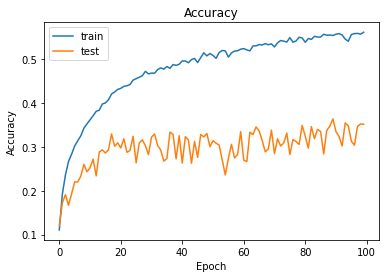

In [9]:
figure = plt.figure().gca()
figure.plot(train_accuracy)
figure.plot(test_accuracy)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy')
plt.show()

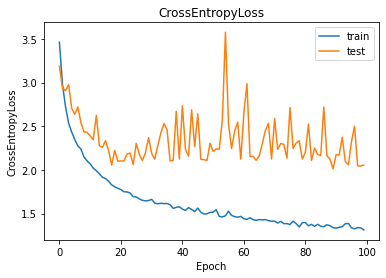

In [10]:
figure = plt.figure().gca()
figure.plot(train_loss)
figure.plot(test_loss)
plt.ylabel('CrossEntropyLoss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('CrossEntropyLoss')
plt.show()

## 1.7 Выводы

В ходе выполнения первого номера ДЗ №3 были проведены эксперименты с агументацией данных и регуляризацией модели. Результат выполнения работы показал, что точность без аугментациии данных и без регуляризации выше, чем точность с аугментацией данных и с регуляризацией.

# 2. Рекуррентная нейронная сеть для генерации текстов (9 баллов)

## 2.1 Загрузка данных



In [2]:
from google.colab import drive

drive.mount('content')

Drive already mounted at content; to attempt to forcibly remount, call drive.mount("content", force_remount=True).


In [3]:
with open('/content/content/MyDrive/oirs_dataset/L_war_and_piece.txt') as text_file:
    text_sample = text_file.readlines()
text_sample = ' '.join(text_sample)

def text_to_seq(text_sample):
    char_counts = Counter(text_sample)
    char_counts = sorted(char_counts.items(), key = lambda x: x[1], reverse=True)

    sorted_chars = [char for char, _ in char_counts]
    print(sorted_chars)
    char_to_idx = {char: index for index, char in enumerate(sorted_chars)}
    idx_to_char = {v: k for k, v in char_to_idx.items()}
    sequence = np.array([char_to_idx[char] for char in text_sample])
    
    return sequence, char_to_idx, idx_to_char

sequence, char_to_idx, idx_to_char = text_to_seq(text_sample)

[' ', 'о', 'е', 'а', 'и', 'н', 'т', 'с', 'л', 'в', 'р', 'к', 'д', ',', 'м', 'у', 'п', 'я', '\n', 'ы', 'ь', 'г', 'б', 'з', 'ч', '.', 'ж', '-', 'й', 'х', 'ш', 'ю', 'ц', 'щ', 'э', 'e', 'Н', 'П', 'ф', 'О', 's', 'В', 'К', 'a', 'М', 'r', 'i', 'n', 'Д', 't', 'o', 'u', '?', ';', 'l', 'И', 'С', 'Т', '!', 'm', '"', 'А', 'd', ')', ':', '(', 'c', '[', ']', 'Р', 'Б', 'Е', '1', 'p', "'", 'I', 'Я', 'Ч', 'Э', 'Г', 'v', '2', 'ъ', 'é', 'Л', 'q', 'V', 'У', 'f', 'Ф', 'g', '3', 'h', 'b', 'З', '8', 'X', 'j', '4', 'Х', 'z', '0', 'M', '5', 'à', '9', 'N', '7', 'Ш', '6', 'x', 'Ж', 'C', 'L', 'ê', 'è', 'y', 'S', 'E', 'B', 'J', '*', 'O', 'D', 'Q', 'Щ', 'A', 'î', 'Ц', 'Ь', 'R', 'ç', 'K', 'ë', 'â', 'P', 'k', 'F', 'G', 'ù', 'œ', 'û', 'ô', 'T', 'Ç', 'w', 'H', 'Ю', '=', '/', '№', 'Ê']


## 2.2 Преодбработка/нормализация данных по необходимости

Например, можно привести все слова к нижнему регистру

In [5]:
len_seq = 256
batch = 16

def get_batch(sequence):
    trains = []
    targets = []
    for _ in range(batch):
        batch_start = np.random.randint(0, len(sequence) - len_seq)
        chunk = sequence[batch_start: batch_start + len_seq]
        train = torch.LongTensor(chunk[:-1]).view(-1, 1)
        target = torch.LongTensor(chunk[1:]).view(-1, 1)
        trains.append(train)
        targets.append(target)
    return torch.stack(trains, dim=0), torch.stack(targets, dim=0)

In [6]:
def evaluate(model, char_to_idx, idx_to_char, start_text=' ', prediction_len=200, temp=0.3):
    hidden = model.init_hidden()
    idx_input = [char_to_idx[char] for char in start_text]
    train = torch.LongTensor(idx_input).view(-1, 1, 1).to(device)
    predicted_text = start_text
    
    _, hidden = model(train, hidden)
        
    inp = train[-1].view(-1, 1, 1)
    
    for i in range(prediction_len):
        output, hidden = model(inp.to(device), hidden)
        output_logits = output.cpu().data.view(-1)
        p_next = F.softmax(output_logits / temp, dim=-1).detach().cpu().data.numpy()        
        top_index = np.random.choice(len(char_to_idx), p=p_next)
        inp = torch.LongTensor([top_index]).view(-1, 1, 1).to(device)
        predicted_char = idx_to_char[top_index]
        predicted_text += predicted_char
    
    return predicted_text

## 2.3 Инициализация объекта рекуррентной нейронной сети

In [7]:
class TextRNN(nn.Module):
    
    def __init__(self):
        super(TextRNN, self).__init__()
        
        self.input_size = len(idx_to_char)
        self.hidden_size = 128
        self.embedding_size = 128
        self.n_layers = 2

        self.encoder = nn.Embedding(self.input_size, self.embedding_size)
        self.rnn = nn.RNN(self.embedding_size, self.hidden_size, self.n_layers)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(self.hidden_size, self.input_size)
        
    def forward(self, x, hidden):
        x = self.encoder(x).squeeze(2)
        out, ht1 = self.rnn(x, hidden)
        out = self.dropout(out)
        x = self.fc(out)
        return x, ht1
    
    def init_hidden(self, batch_size=1):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size, requires_grad=False).to(device)

## 2.4 Обучение обычной рекуррентной нейронной сети

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = TextRNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    patience=5, 
    verbose=True, 
    factor=0.5
)

n_epochs = 10000
loss_avg = []

for epoch in range(n_epochs):
    model.train()
    train, target = get_batch(sequence)
    train = train.permute(1, 0, 2).to(device)
    target = target.permute(1, 0, 2).to(device)
    hidden = model.init_hidden(batch)

    output, hidden = model(train, hidden)
    loss = criterion(output.permute(1, 2, 0), target.squeeze(-1).permute(1, 0))
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    loss_avg.append(loss.item())

    if epoch%500 == 0:
        print("\nEpoch number: ", epoch)
        mean_loss = np.mean(loss_avg)
        print(f'Loss: {mean_loss}')
        scheduler.step(mean_loss)
        model.eval()
        predicted_text = evaluate(model, char_to_idx, idx_to_char)
        print(predicted_text)


Epoch number:  0
Loss: 5.075348377227783
              у   эЭЯГÊbДis   уз          сLQSЧвК5 ц.                   LтaGвюО6д9 Л1z;LоùГльУAXЗC5eму3сùэcoИR*Тi"О"Ч"OLвcЩпÊè?LЛфу)вsПЛпм)a0q      пTБвTnФ8]омБТяfâbп6тЦзLБRРзjЭ      ЩэdгЩИTщôЯеМ6вюVâz

Epoch number:  500
Loss: 1.9930524007526937
 с  умерную  в  востоянно  он  в  он  события,  по  не  и по  столь  с  на  совершенно  в  он  в  он  столь  на  востоянность  от  собою  и  себе  не  было  привысленное  события  собранцузов   события

Epoch number:  1000
Loss: 1.8838190271423294
  приводни   подомно  делает  он  последней,  то  востолько  востоки  и  примерного  не  воспоминая  присудерь   на  после  в  от  придвижения  и  на  востова  и  поднял в  после  при  произведение  и 

Epoch number:  1500
Loss: 1.8376981018385357
      --  Солобе  на  себя и  для  не  был  от  своем  только  не  в  нему  не  должно  событие  только  было  страшно  не  событие  событие  не  воли  должно  последней  образами,  совершенное  столе 

Epoch number

## 2.5 Генерация текстов при помощи обычной рекуррентной сети

In [9]:
model.eval()
model.eval()
print(evaluate(
    model, 
    char_to_idx, 
    idx_to_char, 
    temp=0.3, 
    prediction_len=200, 
    start_text='Большой дуб '
    )
)

Большой дуб войска  все  привознить  события  не  поставление  солдатами  события  события  составлялись  на  не  с  старая  он  войска  события  величивал  поднялся  в  поступого  делал  совершить  подошел  пост


## 2.6 Обучение рекуррентной нейронной сети с LSTM-ячейками

In [10]:
def evaluate(model, char_to_idx, idx_to_char, start_text=' ', prediction_len=200, temp=0.3):
    hidden = model.init_hidden()
    idx_input = [char_to_idx[char] for char in start_text]
    train = torch.LongTensor(idx_input).view(-1, 1, 1).to(device)
    predicted_text = start_text
    
    _, hidden = model(train, hidden)
        
    inp = train[-1].view(-1, 1, 1)
    
    for i in range(prediction_len):
        output, hidden = model(inp.to(device), hidden)
        output_logits = output.cpu().data.view(-1)
        p_next = F.softmax(output_logits / temp, dim=-1).detach().cpu().data.numpy()        
        top_index = np.random.choice(len(char_to_idx), p=p_next)
        inp = torch.LongTensor([top_index]).view(-1, 1, 1).to(device)
        predicted_char = idx_to_char[top_index]
        predicted_text += predicted_char
    
    return predicted_text

In [11]:
class LTSM(nn.Module):
    
    def __init__(self):
        super(LTSM, self).__init__()
        
        self.input_size = len(idx_to_char)
        self.hidden_size = 128
        self.embedding_size = 128
        self.n_layers = 2

        self.encoder = nn.Embedding(self.input_size, self.embedding_size)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.n_layers)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(self.hidden_size, self.input_size)
        
    def forward(self, x, hidden):
        x = self.encoder(x).squeeze(2)
        out, (ht1, ct1) = self.lstm(x, hidden)
        out = self.dropout(out)
        x = self.fc(out)
        return x, (ht1, ct1)
    
    def init_hidden(self, batch_size=1):
        return (torch.zeros(self.n_layers, batch_size, self.hidden_size, requires_grad=True).to(device),
               torch.zeros(self.n_layers, batch_size, self.hidden_size, requires_grad=True).to(device))

In [16]:
model = LTSM()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    patience=5, 
    verbose=True, 
    factor=0.5
)

n_epochs = 10000
loss_avg = []

for epoch in range(n_epochs):
    model.train()
    train, target = get_batch(sequence)
    train = train.permute(1, 0, 2).to(device)
    target = target.permute(1, 0, 2).to(device)
    hidden = model.init_hidden(batch)

    output, hidden = model(train, hidden)
    loss = criterion(output.permute(1, 2, 0), target.squeeze(-1).permute(1, 0))
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    loss_avg.append(loss.item())

In [14]:
model.eval()
model.eval()
print(evaluate(
    model, 
    char_to_idx, 
    idx_to_char, 
    temp=0.3, 
    prediction_len=200, 
    start_text='Большой дуб '
    )
)

Большой дуб и  которые  в  своей  событие  и  в  представлялся  и  только  о нем  в  наших  войска  с  собой  в  другой  того, что он  не  событий  в  том, что  он  не  поступка  и  по
   собой  в  своей  положен


## 2.7 Генерация текстов с разной температурой

Попробуйте сгенерировать тексты с температурой из списка: `[0.1, 0.2, 0.4, 0.6, 0.8, 1.0]` (см. нотубук с семинара по RNN)

In [15]:
temps = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]

for temp in temps:
  model.eval()
  print(evaluate(
      model, 
      char_to_idx, 
      idx_to_char, 
      temp=temp, 
      prediction_len=200, 
      start_text='Большой дуб '
      )
  )

Большой дуб и  не  поступка  и  в  своей  не  страшно  подошел  и  не  страшно  в  своей  войска  с  события  и  он  не  поступка  и  он  не  последний  события  и  в  своей  не  странно  и  не  странно  и  не  с
Большой дуб и  не  стараясь  в  общего  и  не  страх  столько  представлялась  о  события  и  события  и  он  поступка  и  совершенно  до  причина  и  в  настоящего  на  солдат  и  не  подошла  и  просто  и  в  с
Большой дуб с  свои  солдат  и  события в  делами и  поступились  и  последние  и  все  не  только  в  дверь  день к нему в  больше  в  дороге,  и  в  восторженное  на  всем  событиями  и  припадавшиеся  от  них 
Большой дуб не делала  оправдания страдания голову
   отвечали причина, но простопить причино  и  ты  сказала и  в  детских  сила  только милых в удивлялось ее
   мальчик  невозможных поступившими  движение  было
Большой дуб чувства, светился о получие, до  нем вопросов
   конеясятно и представлялись и не  было, как  видимо,  которые повернулась  и  как он
  

## 2.8 Выводы

Обычная рекуррентная сеть дает меньшую точность и генерирует менее подходящие по смыслу тексты.